# Evaluating Automated Stopping

## Setup 

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE
import openTSNE
import time
import json
from math import ceil

# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets
import quality_measures

## Functions 

### KLD and KLDRC Monitor

In [4]:
from openTSNE import callbacks 
class KLDMonitor(callbacks.Callback):
    def __init__(self, record_every=5):
        self.record_every = record_every
        self.kl_divergences = {}
    
    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence while ensuring unique iteration values.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            # in this case we are in the embedding phase  
            if iteration in self.kl_divergences or iteration > 250:
                self.kl_divergences[iteration + 250] = error 
            # in the EE phase     
            else: 
                self.kl_divergences[iteration] = error

In [5]:
buffer_ee = 15
switch_buffer = 2 

class KLDRCMonitorEE(callbacks.Callback):
    def __init__(self, record_every=3):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_ee (int): Minimum iterations before monitoring KL divergence.
            switch_buffer (int): Extra iterations to confirm EE phase exit.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_ee = 3`
        self.kl_divergences = []
        self.rel_changes = [] # this should be a list with entries (iteration, rel_change)
        self.last_error = None
        self.last_rel_change = None
        self.switch_buffer_count = switch_buffer  # Tracks remaining iterations before exiting EE

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop Early Exaggeration.
        Returns True if EE should stop.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute relative change: (prev_error - current_error) / prev_error
                rel_change =(self.last_error - error) / self.last_error  
                self.rel_changes.append((iteration, rel_change))

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Relative Change = {rel_change:.4f}%")

                # Start checking only after `buffer_ee` iterations
                if iteration > buffer_ee:
                    if self.last_rel_change is not None and rel_change < self.last_rel_change:
                        # If relative change decreases, start the switch buffer countdown
                        if self.switch_buffer_count < 1:
                            print("Relative change has consistently decreased. Stopping Early Exaggeration.")
                            print(f"EE Iteration stopped at {iteration}")
                            # Signal to stop EE phase, we return iteration as well 
                            return True, iteration  
                        self.switch_buffer_count -= 1
                    else:
                        # Reset switch buffer if relative change increases again
                        self.switch_buffer_count = switch_buffer

                self.last_rel_change = rel_change

            # Update last error for the next iteration
            self.last_error = error

        return False  # Continue EE phase if conditions are not met

In [6]:
buffer_run = 150 
auto_iter_end = 100 

class KLDRCMonitorRun(callbacks.Callback):
    def __init__(self, record_every=5):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_run (int): Minimum iterations after EE before monitoring for stopping.
            auto_iter_end (float): Threshold for stopping, lower values stop earlier.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_run = 5`
        # self.buffer_run = buffer_run  # Equivalent to `auto_iter_buffer_run = 15`
        # self.auto_iter_end = auto_iter_end  # Used for stopping condition

        self.kl_divergences = []
        self.last_error = None

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop the full t-SNE run.
        Returns True if the run should stop.
        """
        # Only check KL divergence every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute absolute error difference
                error_diff = abs(self.last_error - error)

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Error Diff = {error_diff:.6f}")

                # Start monitoring only after `buffer_run` iterations have passed
                if iteration > buffer_run:
                    # Stopping condition from C++: abs(error_diff)/pollrate < error/auto_iter_end
                    if (error_diff / self.record_every) < (error / auto_iter_end):
                        print("KL divergence change is below threshold. Stopping optimization.")
                        print(f"Run iteration stopped at {iteration}")
                        return True, iteration  # Signal to stop t-SNE run

            # Update last error
            self.last_error = error

        return False  # Continue t-SNE run


### Running t-SNE

In [7]:
def run_optSNE(data, labels, random_state):
    """
    Runs the optimized t-SNE (i.e. with automated stopping) on a given dataset.
    This version accepts data and labels as inputs (instead of using a global DataFrame).
    
    Returns:
      embedding: the final embedding.
      final_kld: final KL divergence value.
      labels: the labels (unchanged).
      kld_monitor: the monitor object containing the KL divergence history.
    """
    # In this version we use the entire dataset.
    features = data  # assuming data is already a numpy array
    
    initiali = openTSNE.initialization.pca(features, random_state=random_state)
    
    # using default perplexity
    affinities = openTSNE.affinity.PerplexityBasedNN(
        features,
        perplexity=30, 
        n_jobs=-1,
        random_state=random_state,
        verbose=True
    )
    
    embedding_obj = openTSNE.TSNEEmbedding(
        initiali, 
        affinities, 
        random_state=random_state,
        verbose=True
    )
    
    # --- Early Exaggeration phase ---
    kld_monitor_EE = KLDRCMonitorEE(record_every=3)
    try:
        embedding_obj = embedding_obj.optimize(
            n_iter=1000, 
            callbacks=kld_monitor_EE, 
            callbacks_every_iters=3, 
            verbose=True
        )
    except Exception as e:
        print("Early Exaggeration phase stopped early:", e)

    # extract results 
    ee_kld = kld_monitor_EE.kl_divergences 
    ee_rel = kld_monitor_EE.rel_changes 
    ee_offset = ee_kld[-1][0] if ee_kld else 0
    
    # --- Embedding phase ---
    kld_tracker_embed = KLDRCMonitorRun(record_every=5)
    try:
        embedding_obj = embedding_obj.optimize(
            n_iter=1000,
            callbacks=kld_tracker_embed, 
            callbacks_every_iters=5, 
            verbose=True
        )
    except Exception as e:
        print("Embedding phase stopped early:", e)

    # kld offset for plotting reasons
    run_kld = [(iteration + ee_offset, error) for (iteration, error) in kld_tracker_embed.kl_divergences]
    combined_kld = ee_kld + run_kld
        
    monitor_data = {
        "kl_divergences": combined_kld,
        "rel_changes": ee_rel
    }
    return embedding_obj, labels, monitor_data

In [8]:
def run_tsne_experiments(datasets, seeds, default_EE=250, verbose=False):
    """
    Runs both normal t-SNE and optimized t-SNE (opt-SNE) on each dataset,
    each with multiple seeds.
    
    Parameters:
      datasets: list of tuples (data, labels)
      seeds: list of seeds (e.g., 3 seeds)
      default_EE: fixed early exaggeration iterations for normal t-SNE
      verbose: verbosity flag
      
    Returns:
      embeddings: dict with keys ((dataset_index, setting), seed) mapping to 
                  (embedding, labels, kld_history)
      timings: list of dicts with timing info.
    """
    embeddings = {}
    timings = []
    
    for d_idx, (data, labels) in enumerate(datasets):
        if hasattr(data, "values"):
            data = data.values.astype(float)

        for seed in seeds:
            # --- Run normal t-SNE with default settings ---
            # using normal kld monitor
            kld_monitor_norm = KLDMonitor()  
            tsne_norm = TSNE(early_exaggeration_iter=default_EE, 
                             n_iter=750 - default_EE, 
                             n_jobs=-1,
                             callbacks=kld_monitor_norm, 
                             callbacks_every_iters=5,
                             random_state=seed, 
                             verbose=verbose)
            t0 = time.time()
            embedding_norm = tsne_norm.fit(data)
            elapsed_normal = time.time() - t0
            kld_norm = kld_monitor_norm.kl_divergences
            embeddings[((d_idx, "normal"), seed)] = (embedding_norm, labels, kld_norm)
            timings.append({
                "dataset_index": d_idx, 
                "setting": "normal", 
                "seed": seed, 
                "time_taken_seconds": elapsed_normal
            })
            
            # --- Run optimized t-SNE (opt-SNE) ---
            t0 = time.time()
            embedding_opt, labels_opt, monitor_data = run_optSNE(
                data, labels, random_state=seed)
            elapsed_opt = time.time() - t0
        
            embeddings[((d_idx, "opt"), seed)] = (embedding_opt, labels_opt, monitor_data)
            timings.append({
                "dataset_index": d_idx, 
                "setting": "opt", 
                "seed": seed, 
                "time_taken_seconds": elapsed_opt
            })
            
    # Optionally, save timings to a file.
    save_path = os.path.join(results_dir, "opt-SNE_times.json")
    with open(save_path, "w") as f:
        json.dump(timings, f, indent=4)
        
    return embeddings

### Embedding Grid Plotting

In [9]:
def plot_embedding_grid_experiments(embeddings, seeds, dataset_ids, file_start="opt-SNE", cmap="tab20"):
    """
    Plots a grid of t-SNE embeddings from experiments.
    Rows correspond to seeds and columns correspond to each (dataset, setting) combination.
    Column order: for each dataset, first "normal" then "opt".
    
    Parameters:
      embeddings (dict): Dictionary with keys ((dataset_index, setting), seed) mapping to 
                         (embedding, labels, kld_history).
      seeds (list): List of seeds used.
      dataset_ids (list): List of dataset indices or names (hashable).
      file_start (str): Prefix for the saved filename.
      cmap (str): Colormap to use.
    """
    # Build column parameter list: one entry per (dataset, setting) combination.
    column_parameters = []
    for d in dataset_ids:
        column_parameters.append((d, "normal"))
        column_parameters.append((d, "opt"))
        
    row_parameters = seeds  # each row is one seed
    n_rows = len(row_parameters)
    n_cols = len(column_parameters)
    
    subplot_size = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, subplot_size * n_rows), squeeze=False)
    # fig.suptitle("t-SNE Embeddings", fontsize=12)
    
    for r_idx, seed in enumerate(row_parameters):
        for c_idx, col in enumerate(column_parameters):
            ax = axes[r_idx, c_idx]
            key = (col, seed)
            if key not in embeddings:
                ax.axis("off")
                continue
            embedding, labels, _ = embeddings[key]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=2, alpha=0.6)
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
            # For the top row, add a title showing dataset and setting.
            if r_idx == 0:
                d_idx, setting = col
                ax.set_title(f"{setting}", fontsize=12, pad=10)
            # For the left-most column, add a label showing the seed.
            #if c_idx == 0:
            #    ax.set_ylabel(f"Seed: {seed}", fontsize=12, labelpad=10)
                
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)
    save_path = os.path.join(figures_dir, f"{file_start}_embedding_grid_{cmap}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### Plot KL Divergences

In [10]:
def plot_kld_monitors(embeddings, dataset_ids, seed_for_kld=42, file_start="opt-SNE", mode="opt"):
    """
    Plots, for each dataset, the KL divergence and relative change curves (from opt-SNE)
    for a specified seed, arranged in a single row (one subplot per dataset).

    Each subplot will have two y-axes:
      - Left y-axis for KLD (blue curve)
      - Right y-axis for KLDRC (red curve)
    The first subplot includes a combined legend.

    The secondary y-axis is adjusted such that the maximum KLDRC value appears at only 60%
    of the total height of the plot.

    Parameters:
      embeddings (dict): Dictionary with keys ((dataset_index, setting), seed) mapping to 
                         (embedding, labels, monitor_data) where monitor_data is a dict with:
                           "kl_divergences": list of (iteration, kld_error)
                           "rel_changes": list of (iteration, rel_change)
      dataset_ids (list): List of dataset identifiers (e.g., indices or names) which are hashable.
      seed_for_kld: The seed to use for plotting.
      file_start (str): Prefix for the saved filename.
      mode (str): Which setting to use (e.g. "opt").
    """
    # Mapping dataset identifier to title.
    title_mapping = {0: "Macosko", 1: "MNIST", 2: "Flow18"}
    
    n_datasets = len(dataset_ids)
    fig, axes = plt.subplots(1, n_datasets, figsize=(12, 4))
    if n_datasets == 1:
        axes = [axes]
    
    for i, d in enumerate(dataset_ids):
        key = ((d, mode), seed_for_kld)
        if key not in embeddings:
            axes[i].axis("off")
            continue

        # Extract the monitor data dictionary.
        monitor_data = embeddings[key][2]
        kl_divs = monitor_data.get("kl_divergences", [])
        rel_changes = monitor_data.get("rel_changes", [])
        
        # Separate iterations and values.
        iterations_kld = [it for it, val in kl_divs]
        kld_values     = [val for it, val in kl_divs]
        
        iterations_rel = [it for it, val in rel_changes]
        rel_values     = [val for it, val in rel_changes]
        
        # Create twin y-axes.
        ax = axes[i]
        ax2 = ax.twinx()
        
        # Plot KLD on the left axis (blue) and KLDRC on the right (red).
        l1, = ax.plot(iterations_kld, kld_values, color='blue', label="KLD")
        l2, = ax2.plot(iterations_rel, rel_values, color='red', label="KLDRC")
        
        ax.set_xlabel("Iteration", fontsize=12)
        if i == 0: 
          ax.set_ylabel("KLD", fontsize=12, color='black')
          ax2.set_ylabel("KLDRC", fontsize=12, color='black')
        
        # Set the title using our mapping.
        ax.set_title(title_mapping.get(d, str(d)), fontsize=12)
        
        # Set tick labels to black.
        ax.tick_params(axis="y", labelcolor='black')
        ax2.tick_params(axis="y", labelcolor='black')    
        
        # Omit the top spine for both axes.
        ax.spines["top"].set_visible(False)
        ax2.spines["top"].set_visible(False)
        # Optionally hide the right spine of the primary axis.
        # ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)
        ax2.spines["right"].set_linewidth(0.5)
        ax2.spines["left"].set_linewidth(0.5)
        ax2.spines["bottom"].set_linewidth(0.5)
        
        # Adjust the secondary y-axis so that its max value is at 60% of the axis height.
        if rel_values:
            max_rel = max(rel_values)
            ax2.set_ylim(0, max_rel / 0.6)
        
        # Only add a combined legend in the first subplot.
        if i == 0:
            lines = [l1, l2]
            labels = [line.get_label() for line in lines]
            ax.legend(lines, labels, fontsize=10, loc='upper right')
    
    plt.tight_layout()
    save_path = os.path.join(figures_dir, f"{file_start}_kl_divergences_plot.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### Quality Plotting for Different Seeds

In [11]:
def average_quality_measures(embedding_dict, X_list):
    """
    Computes the average quality measures across different seeds for each dataset and setting,
    and also stores individual seed results.
    
    Parameters:
        embedding_dict (dict): Dictionary with keys ((dataset_index, setting), seed)
                               mapping to (embedding, labels, monitor_data).
        X_list (list): List of numpy.ndarrays corresponding to the original high-dimensional data 
                       for each dataset. For example, X_list[d] is the data for dataset d.
    
    Returns:
        dict: Dictionary with keys (dataset_index, setting) mapping to another dictionary:
              {
                  "average": (mnn_avg, mnn_global_avg, rho_avg),
                  "seeds": {seed: (mnn, mnn_global, rho), ...}
              }
    """
    quality_results = {}
    # Get unique (dataset_index, setting) pairs.
    unique_keys = {key[0] for key in embedding_dict.keys()}
    
    for ds_key in unique_keys:
        d_idx, setting = ds_key
        mnn_list, mnn_global_list, rho_list = [], [], []
        seed_results = {}
        # Loop over all seeds for this dataset and setting.
        for key in embedding_dict.keys():
            if key[0] == ds_key:
                seed = key[1]
                embedding, labels, _ = embedding_dict[key]
                # Compute quality measures using the high-dimensional data for dataset d_idx.
                mnn, mnn_global, rho = quality_measures.embedding_quality(X_list[d_idx], embedding, labels)
                mnn_list.append(mnn)
                mnn_global_list.append(mnn_global)
                rho_list.append(rho)
                seed_results[seed] = (mnn, mnn_global, rho)
                
        quality_results[ds_key] = {
            "average": (np.mean(mnn_list), np.mean(mnn_global_list), np.mean(rho_list)),
            "seeds": seed_results
        }
        
    return quality_results

In [12]:
def plot_quality_measures(quality_results, dataset_names, show_variance=True, plot_name="opt-SNE"):
    """
    Plots three side-by-side plots for the three embedding quality measures (KNN, KNC, CPD).
    X-axis represents "normal" vs. "opt" t-SNE. Each dataset is plotted separately.
    Lighter lines show individual seeds when `show_variance=True`.

    Parameters:
        embedding_dict (dict): Output from `run_tsne_experiments()`, containing embeddings, labels, and monitor data.
        X_list (list): List of high-dimensional datasets (each dataset's `X` values).
        dataset_names (list): List of dataset names in order (e.g., ["Macosko", "MNIST", "Flow18"]).
        show_variance (bool): If True, plots individual seed results in lighter colors.
        plot_name (str): Filename prefix for saving the plot.
    """

    # Define t-SNE settings for x-axis ("normal" vs. "opt")
    tsne_settings = ["normal", "opt"]

    # Extract dataset indices
    dataset_indices = range(len(dataset_names))

    # Prepare data structures
    dataset_data = {d: {'mnn': [], 'mnn_global': [], 'rho': []} for d in dataset_indices}
    seed_data = {d: {'mnn': {}, 'mnn_global': {}, 'rho': {}} for d in dataset_indices}  # Store per-seed values

    # Populate dataset_data and seed_data
    for d in dataset_indices:
        for setting in tsne_settings:
            key = (d, setting)
            if key in quality_results:
                avg_mnn, avg_mnn_global, avg_rho = quality_results[key]["average"]
                dataset_data[d]['mnn'].append(avg_mnn)
                dataset_data[d]['mnn_global'].append(avg_mnn_global)
                dataset_data[d]['rho'].append(avg_rho)

                # Store per-seed results
                for seed, (mnn, mnn_global, rho) in quality_results[key]["seeds"].items():
                    if seed not in seed_data[d]['mnn']:
                        seed_data[d]['mnn'][seed] = []
                        seed_data[d]['mnn_global'][seed] = []
                        seed_data[d]['rho'][seed] = []
                    seed_data[d]['mnn'][seed].append(mnn)
                    seed_data[d]['mnn_global'][seed].append(mnn_global)
                    seed_data[d]['rho'][seed].append(rho)

    # Create 1x3 subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["KNN", "KNC", "CPD"]
    colors = ["blue", "darkviolet", "red"]  # Colors for datasets

    # Loop through quality metrics
    for i, (metric, title) in enumerate(zip(['mnn', 'mnn_global', 'rho'], titles)):
        for d, data in dataset_data.items():
            # Plot per-seed results (lighter lines)
            if show_variance:
                # print("starting new plotting of seeds")
                for seed in seed_data[d][metric]:
                   # print("plotting a seed")
                    axes[i].plot(tsne_settings, seed_data[d][metric][seed], linestyle='-', color=colors[d], alpha=0.3)

            # Plot averaged results (bold lines)
            axes[i].plot(tsne_settings, data[metric], marker='o', linestyle='-', color=colors[d], label=dataset_names[d])

        # Format subplot
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xticks(tsne_settings)

    # Formatting: Remove top/right spines, keep black y-labels
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5, colors="black")
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)

    # Only include legend in the first plot
    axes[0].legend(fontsize=10)

    plt.tight_layout()

    # Save and display the figure
    save_path = os.path.join(figures_dir, f"{plot_name}_3_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


## Experiments

In [13]:
all_data = datasets.load_all_datasets()

In [14]:
# for testing a smaller number of datapoints 
#n_points = 700
# all_data = [datasets.load_n_samples(n_points, X, y) for (X, y) in all_data[1:]]

In [15]:
seeds = [1, 12, 42]

In [16]:
embeddings_dict = run_tsne_experiments(all_data, seeds=seeds) 

===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=150.00 for 1000 iterations...
Iteration 6: KL Divergence = 1.5276, Relative Change = -0.0008%
Iteration 9: KL Divergence = 0.9522, Relative Change = 0.3767%
Iteration 12: KL Divergence = 0.2936, Relative Change = 0.6916%
Iteration 15: KL Divergence = 0.1973, Relative Change = 0.3282%
Iteration 18: KL Divergence = 0.1845, Relative Change = 0.0647%
Iteration 21: KL Divergence = 0.1717, Relative Change = 0.0696%
Iteration 24: KL Divergence = 0.1679, Relative Change = 0.0220%
Iteration 27: KL Divergence = 0.1613, Relative Change = 0.0394%
Iteration 30: KL Divergence = 0.1561, Relative Change = 0.0322%
Iteration 33: KL Divergence = 0.1530, Relative Change = 0.0196%
Iteration 36: KL Divergence = 0.1450, Relative Change = 0.0520%
Iteration 39: KL Divergence =

In [17]:
embedding_opt, labels_opt, monitor_data = embeddings_dict[((0, "opt"), 1)]

In [18]:
kld_opt = monitor_data["kl_divergences"]    
rel_changes = monitor_data["rel_changes"]     

# Print the values:
print("KL Divergences (Iteration, Value):")
for iteration, kld_value in kld_opt:
    print(f"Iteration {iteration}: {kld_value}")

print("\nKL Divergence Relative Changes (Iteration, Value):")
for iteration, rel_change in rel_changes:
    print(f"Iteration {iteration}: {rel_change}")

KL Divergences (Iteration, Value):
Iteration 3: 1.526342182010369
Iteration 6: 1.527578635612203
Iteration 9: 0.9521538401270195
Iteration 12: 0.2936224270160359
Iteration 15: 0.19725715487834883
Iteration 18: 0.18449153966525245
Iteration 21: 0.17165185316716336
Iteration 24: 0.1678775575050091
Iteration 27: 0.16125562932379722
Iteration 30: 0.15606977944472256
Iteration 33: 0.15301205298993104
Iteration 36: 0.14504945151275095
Iteration 39: 0.14681185276157915
Iteration 42: 0.1451664134043309
Iteration 45: 0.14258822443779717
Iteration 48: 0.14099971280407786
Iteration 51: 0.13972321313959934
Iteration 54: 0.13992590146892692
Iteration 59: 0.13880945015897872
Iteration 64: 0.13762135545939191
Iteration 69: 0.13713134460239296
Iteration 74: 0.1361779013502149
Iteration 79: 0.13644766796003438
Iteration 84: 0.1360265802263534
Iteration 89: 0.1349578783952463
Iteration 94: 0.1340050919017921
Iteration 99: 0.13368550256659528
Iteration 104: 0.13280910623846598
Iteration 109: 0.1326231682

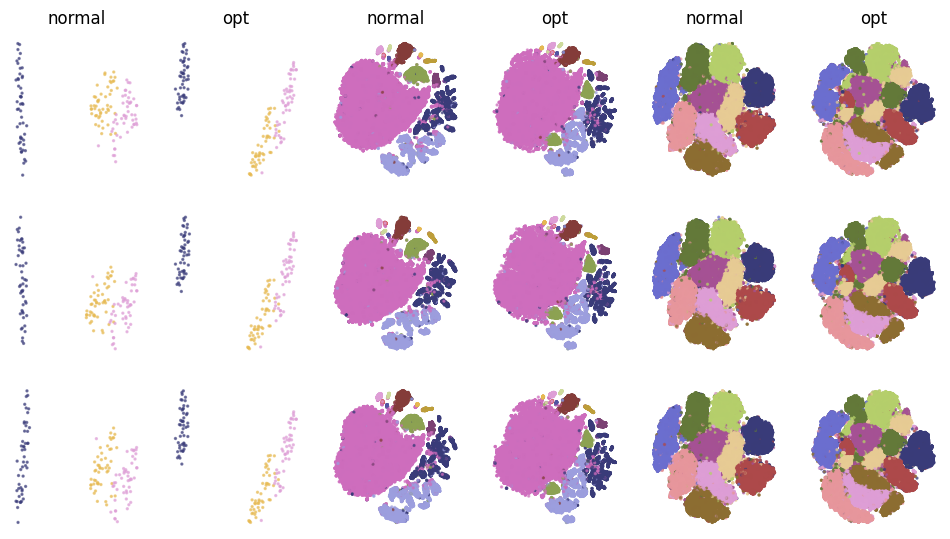

In [19]:
plot_embedding_grid_experiments(embeddings_dict, seeds, [0,1,2], cmap="tab20b")

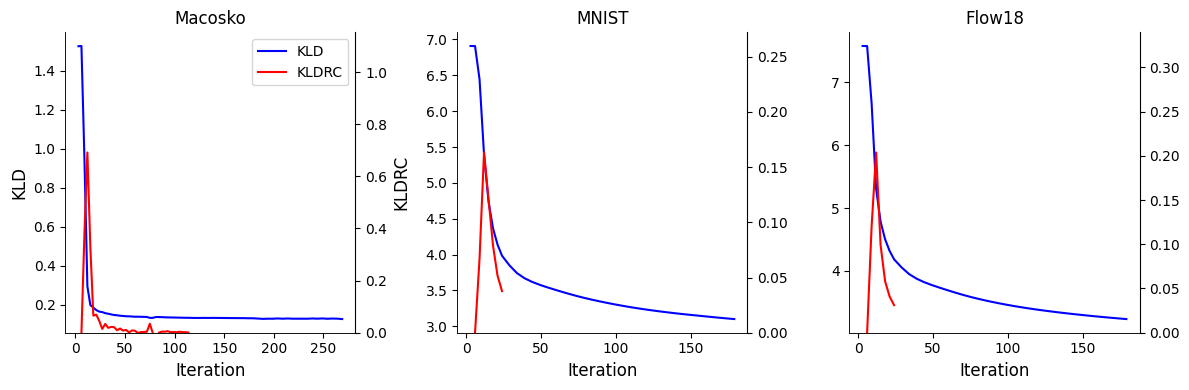

In [20]:
plot_kld_monitors(embeddings_dict, [0,1,2], 42)

In [21]:
X_list = [X for X, y in all_data]

In [22]:

quality_results = average_quality_measures(embeddings_dict, X_list)

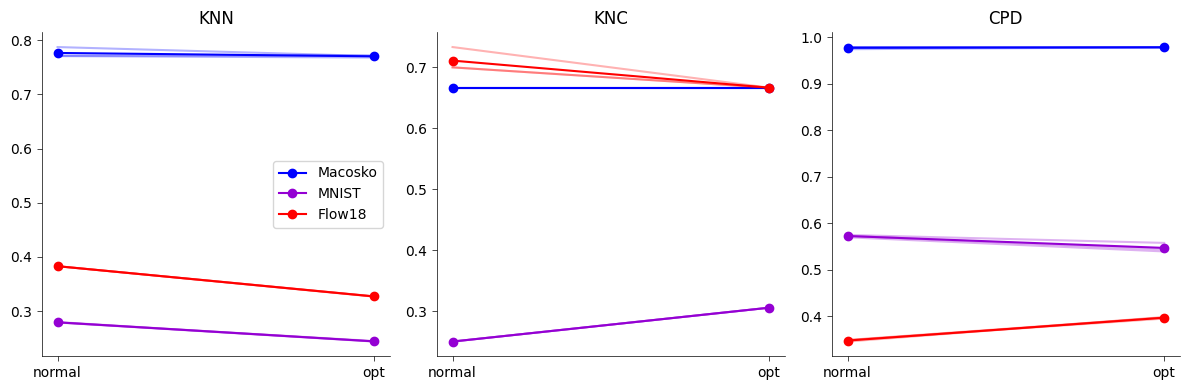

In [23]:
plot_quality_measures(quality_results, ["Macosko", "MNIST", "Flow18"])

: 